## **Catégorisez automatiquement des questions**

### partie 4/8 : Prédiction de tags, approche supervisée + tracking mlflow

#### <br> Notebook d’exploration et de pré-traitement des questions, comprenant une analyse univariée et multivariée, un nettoyage des questions, un feature engineering de type bag of words avec réduction de dimension (du vocabulaire et des tags) 

<br>


## 1 Import


### 1.1 Librairies


In [1]:
import os, sys, random
import ast
import numpy as np
import pandas as pd
from typing import Tuple
from pandarallel import pandarallel
from pprint import pprint
from collections import Counter

# Visualisation
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from PIL import Image

# NLP
from bs4 import BeautifulSoup
import re, string
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# gensim
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.matutils import corpus2dense
from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel, CoherenceModel
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
from gensim import similarities
from gensim.models.ldamulticore import LdaMulticore

# sklearn
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.metrics import make_scorer, PredictionErrorDisplay, r2_score
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

#tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# mlflow
import mlflow
from mlflow import MlflowClient
from mlflow.models.signature import infer_signature, ModelSignature #, Schema, ParamSchema
from mlflow.types import Schema, ParamSchema, ParamSpec, ColSpec

# os.environ['MLFLOW_TRACKING_URI'] = './'

# ! REQUIRES CONSOLE COMMAND : mlflow ui
# depuis dossier notebooks

# Utilisable seulement en local...
mlflow.set_tracking_uri("http://localhost:5000")
client = MlflowClient(tracking_uri="http://127.0.0.1:5000")

# verif, reglages
print('\nPython version ' + sys.version)
print('pyLDAvis version ' + pyLDAvis.__version__)

# Modify if necessary
num_cores = os.cpu_count()
print(f"\nNumber of CPU cores: {num_cores}")
pandarallel.initialize(progress_bar=False, nb_workers=6)


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
2024-02-29 17:43:44.430383: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ubuntu/anaconda3/envs/myenv_p5/lib/python3.11/site-packages/tensorflow/python/debug


Python version 3.11.5 (main, Sep 11 2023, 13:23:44) [GCC 11.2.0]
pyLDAvis version 3.4.0

Number of CPU cores: 8
INFO: Pandarallel will run on 6 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### 1.2 Functions


In [2]:
# dataframe manipulation, NLP

def get_missing_values(df):
    """Generates a DataFrame containing the count and proportion of missing values for each feature.

    Args:
        df (pandas.DataFrame): The input DataFrame to analyze.

    Returns:
        pandas.DataFrame: A DataFrame with columns for the feature name, count of missing values,
        count of non-missing values, proportion of missing values, and data type for each feature.
    """
    # Count the missing values for each column
    missing = df.isna().sum()

    # Calculate the percentage of missing values
    percent_missing = df.isna().mean() * 100

    # Create a DataFrame to store the results
    missings_df = pd.DataFrame({
        'column_name': df.columns,
        'missing': missing,
        'present': df.shape[0] - missing,  # Count of non-missing values
        'percent_missing': percent_missing.round(2),  # Rounded to 2 decimal places
        'type': df.dtypes
    })

    # Sort the DataFrame by the count of missing values
    missings_df.sort_values('missing', inplace=True)

    return missings_df

# with pd.option_context('display.max_rows', 1000):
#   display(get_missing_values(df))


def quick_look(df, miss=True):
    """
    Display a quick overview of a DataFrame, including shape, head, tail, unique values, and duplicates.

    Args:
        df (pandas.DataFrame): The input DataFrame to inspect.
        check_missing (bool, optional): Whether to check and display missing values (default is True).

    The function provides a summary of the DataFrame, including its shape, the first and last rows, the count of unique values per column, and the number of duplicates.
    If `check_missing` is set to True, it also displays missing value information.
    """
    print(f'shape : {df.shape}')

    display(df.head())
    display(df.tail())

    print('uniques :')
    display(df.nunique())

    print('Doublons ? ', df.duplicated(keep='first').sum(), '\n')

    if miss:
        display(get_missing_values(df))


def preprocess_text(text):
    #Cleaning
    text = BeautifulSoup(text, 'html.parser').get_text()
    text = text.lower().strip()

    # Tokenization
    try:
        tokens = nltk.word_tokenize(text)
        tokenizer = nltk.RegexpTokenizer(r'\w+')
        tokens = tokenizer.tokenize(" ".join(tokens))  # Apply RegexpTokenizer to the entire list

        # Remove punctuation (make sure, RegexpTokenizer should have done it already)
        tokens = [token for token in tokens if token not in string.punctuation]

    except Exception as e:
        print(f"Error in tokenization: {e}")
        return []

    # Lemmatization
    lemmatizer = WordNetLemmatizer()

    # Get part of speech for each token
    pos_tags = nltk.pos_tag(tokens)
    lemmatized_tokens = []

    for token, pos_tag in pos_tags:
        # ! Uncommenting next line may crash the cell
        # print(f"Token: {token}, POS Tag: {pos_tag}")
        if pos_tag.startswith('V'):
            # On garde
            lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='v'))
            # Returns the input word unchanged if it cannot be found in WordNet.
        elif pos_tag.startswith('N'):
            # On garde
            try:
                lemmatized_tokens.append(lemmatizer.lemmatize(token, pos='n'))
            except Exception as e:
                print(f"Error lemmatizing verb {token}: {e}")
        # Sinon on supprime

    # Read forbidden words (stopwords, too frequent, too rare) from the file
    with open('./forbidden_words.txt', 'r') as file:
        forbidden = [line.strip() for line in file]

    filtered_list = [token for token in lemmatized_tokens if token not in forbidden]

    # keep uniques
    seen_tokens = set()
    unique_tokens = []

    for token in filtered_list:
        if token not in seen_tokens:
            seen_tokens.add(token)
            if len(token) > 2:
                unique_tokens.append(token)

    return unique_tokens


def turn_str_back_into_list(df):
    """Correct the type change due to .csv export"""

    df['title_nltk'] = df['title_nltk'].apply(ast.literal_eval)
    df['body_nltk'] = df['body_nltk'].apply(ast.literal_eval)
    df['title_spacy'] = df['title_spacy'].apply(ast.literal_eval)
    df['body_spacy'] = df['body_spacy'].apply(ast.literal_eval)
    df['all_tags'] = df['all_tags'].apply(ast.literal_eval)



In [3]:
# mlflow

def create_mlflow_experiment(
    experiment_name: str, artifact_location: str, tags: dict[str, str]
) -> str:
    """
    Create a new mlflow experiment with the given name and artifact location.

    Parameters:
    ----------
    experiment_name: str
        The name of the experiment to create.
    artifact_location: str
        The artifact location of the experiment to create.
    tags: dict[str,Any]
        The tags of the experiment to create.

    Returns:
    -------
    experiment_id: str
        The id of the created experiment.
    """
    try:
        experiment_id = mlflow.create_experiment(
            name=experiment_name, artifact_location=artifact_location, tags=tags
        )
    except:
        print(f"Experiment {experiment_name} already exists.")
        experiment_id = mlflow.get_experiment_by_name(experiment_name).experiment_id

    mlflow.set_experiment(experiment_name=experiment_name)

    return experiment_id


def get_mlflow_experiment(
    experiment_id: str = None, experiment_name: str = None
) -> mlflow.entities.Experiment:
    """
    Retrieve the mlflow experiment with the given id or name.

    Parameters:
    ----------
    experiment_id: str
        The id of the experiment to retrieve.
    experiment_name: str
        The name of the experiment to retrieve.

    Returns:
    -------
    experiment: mlflow.entities.Experiment
        The mlflow experiment with the given id or name.
    """
    if experiment_id is not None:
        experiment = mlflow.get_experiment(experiment_id)
    elif experiment_name is not None:
        experiment = mlflow.get_experiment_by_name(experiment_name)
    else:
        raise ValueError("Either experiment_id or experiment_name must be provided.")

    return experiment


In [4]:
# ! This needs mlfow ui console command first -> unusable on remote server
# all_experiments = client.search_experiments()
# pprint(all_experiments)


### 1.3 Data


In [5]:
raw_data = pd.read_csv('./../0_data/cleaned_data/bow_classic.csv', sep=',')

turn_str_back_into_list(raw_data)

display(raw_data.tail())

print(raw_data.shape)

feature = 'title_nltk'


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy
47660,2011-05-23 22:22:56,How can I send a file document to the printer ...,Here's the basic premise:\nMy user clicks some...,"[c#, winforms, pdf, .net-4.0, printing]","[send, file, document, printer, print]","[send, file, document, printer, print, premise...","[send, file, document, printer, print]","[premise, user, click, file, spit, desktop, wa..."
47661,2011-05-23 21:15:51,CA1014 Mark 'some.dll' with CLSCompliant(true)...,"When I run StyleCop, I got this error message ...","[visual-studio, visual-studio-2010, dll, style...","[mark, dll, error, message, vs2010]","[mark, dll, error, message, vs2010, run, get, ...","[error, message]","[run, error, message, need, mark, dll, set, dl..."
47662,2011-05-23 21:05:59,How to change a text file's name in C++?,"I would like to change a txt file's name, but ...","[c++, algorithm, file, directory, file-rename]","[change, text, file, name, c]","[change, text, file, name, c, like, change, tx...","[change, text, file]","[like, change, txt, file, find, example, want,..."
47663,2011-05-23 20:06:35,php implode (101) with quotes,Imploding a simple array \nwould look like th...,"[php, arrays, string, csv, implode]","[php, quote]","[php, quote, array, look, array, array, lastna...",[quote],"[implode, array, look, array, email, phone, ar..."
47664,2011-05-23 20:00:57,What characters are allowed in a iOS file name?,I'm looking for a way to make sure a string ca...,"[ios, file, filenames, character-encoding, nsf...","[character, allow, file, name]","[character, allow, file, name, look, way, make...","[character, allow, file]","[look, way, string, file, section, code, delet..."


(47665, 8)


### 1.4 Checkpoint : sample + ttsplit


In [6]:
# pour parcourir rapidement la premiere partie du ntbk
quick_df = raw_data[::20]

train_df, test_df = train_test_split(quick_df, test_size=0.1, random_state=42)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

print(train_df.shape)
print(test_df.shape)


(2145, 8)
(239, 8)


## 2 KNN


In [7]:
# Often gives good results if enough data
# relatively fast to train
# Accepts basically any input, as long as it is numerical

# => Perfect for testing different embeddings !


### 2.1 Dummy knn : il copie sur le + proche voisin


In [8]:
# Notre baseline
# Pour ce premier modèle je voulais quelque chose de simple, pour pouvoir tester les scores.
# Donc on n'utilise pas la méthode .predict() du knn, seulement la méthode .kneighbors(),
# disponible après l'entrainement (=le fit). Enuite on va regarder et return les n tags les + frequents
# parmi les tags des voisins (ici, 1 seul voisin, le + proche).


def predict_tags_using_dummy_knn(df, feature=feature, target='all_tags', k=1, exemple=None):
    documents = df[feature].tolist()
    gensim_dictionary = Dictionary(documents)
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]
    print(len(corpus))

    # Convert Gensim corpus to dense matrix
    dense_matrix = corpus2dense(corpus, num_terms=len(gensim_dictionary)).T
    print(dense_matrix.shape, '\n')

    # Ici on ne va pas demander au knn de faire de prediction,
    # On veut juste qu'il trouve les voisins.
    # Mais la fonction fit a besoin de targets en param
    target_values = df[target].values

    # Initialize kNN model
    knn_model = KNeighborsRegressor(n_neighbors=k, metric='cosine', algorithm='brute')
    # print(knn_model.n_neighbors)

    knn_model.fit(dense_matrix, target_values)

    # Example query
    query_document = exemple
    query_bow = gensim_dictionary.doc2bow(query_document)
    query_vector = corpus2dense([query_bow], num_terms=len(gensim_dictionary)).T

    # Find nearest neighbors
    _, indices = knn_model.kneighbors(query_vector)

    # Aggregate tags from neighbors
    neighbor_tags = [tag for i in indices.flatten() for tag in df.iloc[i][target]]

    print(neighbor_tags)

    # Predict tags based on most common tags among neighbors
    predicted_tags = [tag for tag, _ in Counter(neighbor_tags).most_common(n=10)]
    # 5 tags/question en moyenne mais on peut suggérer +

    return predicted_tags, knn_model


exemple = ["your", 'text', 'document', 'javascript']
print(exemple, '\n')

predicted_tags, knn_test = predict_tags_using_dummy_knn(df=train_df, exemple=exemple)
print(predicted_tags, '\n')

# javascript ok


['your', 'text', 'document', 'javascript'] 

2145
(2145, 2196) 

['javascript', 'jquery', 'html', 'dom', 'document-ready']
['javascript', 'jquery', 'html', 'dom', 'document-ready'] 



### 2.2 knn basic


In [9]:
# Mm principe mais on peut choisir le nombre de voisins (-> paramètre à optimiser)
# add score


def predict_tags_using_knn(df, feature=feature, target='all_tags', k=50, exemple=None):
    documents = df[feature].tolist()
    gensim_dictionary = Dictionary(documents)
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]

    # Convert Gensim corpus to dense matrix
    dense_matrix = corpus2dense(corpus, num_terms=len(gensim_dictionary)).T

    # Ici on ne va pas demander au knn de faire de prediction,
    # On veut juste qu'il trouve les voisins.
    # Mais la fonction fit a besoin de targets en param
    target_values = df[target].values

    # Initialize kNN model
    knn_model = KNeighborsRegressor(n_neighbors=k, metric='cosine', algorithm='brute')
    knn_model.fit(dense_matrix, target_values)

    # Example query
    query_document = exemple
    query_bow = gensim_dictionary.doc2bow(query_document)
    query_vector = corpus2dense([query_bow], num_terms=len(gensim_dictionary)).T

    # Find nearest neighbors
    _, indices = knn_model.kneighbors(query_vector)

    # Aggregate tags from neighbors
    neighbor_tags = [tag for i in indices.flatten() for tag in df.iloc[i][target]]

    print(neighbor_tags)

    # Predict tags based on most common tags among neighbors
    predicted_tags = [tag for tag, _ in Counter(neighbor_tags).most_common(n=10)]
    # 5 tags/question en moyenne mais on peut suggérer +

    return query_vector, predicted_tags



### 2.3 predictions (input = list)


In [10]:
exemple1 = ["your", 'text', 'document', 'javascript']
print(exemple, '\n')

_, predicted_tags1 = predict_tags_using_knn(df=train_df, exemple=exemple1)
print(predicted_tags1, '\n') # most frequent, sorted

# javascript ok


['your', 'text', 'document', 'javascript'] 

['javascript', 'jquery', 'html', 'dom', 'document-ready', 'javascript', 'reactjs', 'functional-programming', 'immutability', 'immutable.js', 'javascript', 'jquery', 'ajax', 'asp.net-mvc-3', 'url', 'user-interface', 'text', 'dart', 'flutter', 'marquee', 'javascript', 'html', 'google-chrome', 'error-handling', 'http-status-code-404', 'ios', 'objective-c', 'swift', 'event-handling', 'uitextfielddelegate', 'javascript', 'reactjs', 'sublimetext3', 'babeljs', 'jsx', 'python', 'machine-learning', 'neural-network', 'nlp', 'keras', 'android', 'user-interface', 'text', 'imageview', 'tablelayout', 'sql', 'oracle', 'view', 'oracle9i', 'ora-00932', 'javascript', 'text', 'svg', 'd3.js', 'geometry', 'android', 'android-alertdialog', 'android-dialogfragment', 'android-dialog', 'android-6.0-marshmallow', 'excel', 'api', 'translation', 'google-translate', 'deepl', 'javascript', 'jquery', 'math', 'modulo', 'negative-number', 'python', 'parsing', 'text', 'file-

In [11]:
exemple2 = ["your", 'text', 'document', 'python']
print(exemple2, '\n')

_, predicted_tags2 = predict_tags_using_knn(df=train_df, exemple=exemple2)
print(predicted_tags2, '\n')

# python


['your', 'text', 'document', 'python'] 

['python', 'parsing', 'text', 'file-io', 'python-2.7', 'python', 'html', 'web-scraping', 'text', 'beautifulsoup', 'python', 'matplotlib', 'plot', 'visualization', 'histogram', 'python', 'python-3.x', 'operators', 'matrix-multiplication', 'python-3.5', 'user-interface', 'text', 'dart', 'flutter', 'marquee', 'python', 'opencv', 'image-processing', 'computer-vision', 'ocr', 'python', 'asynchronous', 'async-await', 'generator', 'python-asyncio', 'python', 'python-3.x', 'linux', 'ubuntu', 'unicode', 'python', 'machine-learning', 'neural-network', 'nlp', 'keras', 'android', 'android-alertdialog', 'android-dialogfragment', 'android-dialog', 'android-6.0-marshmallow', 'python', 'comments', 'terminology', 'code-analysis', 'pep8', 'python', 'macos', 'serial-port', 'usb', 'pyserial', 'python', 'multithreading', 'concurrency', 'locking', 'python-import', 'android', 'user-interface', 'text', 'imageview', 'tablelayout', 'python', 'selenium', 'asynchronous', '

In [12]:
exemple = test_df[feature][0]
print(exemple, '\n')

# Call the function with your DataFrame and the desired text feature and target tags
_, predicted_tags = predict_tags_using_knn(df=train_df, exemple=exemple)
print(predicted_tags, '\n')

# firebase peut etre predit, (ou java selon taille datast test)
# grand succes !


['read', 'pdf', 'file', 'asset', 'folder'] 

['c++', 'windows', 'compilation', 'compiler-construction', 'object-files', 'java', 'tomcat', 'maven-2', 'pom.xml', 'properties-file', 'c++', 'optimization', 'gcc', 'x86-64', 'numerical-methods', 'scala', 'hadoop', 'apache-spark', 'hive', 'pyspark', 'c#', '.net', 'string', 'file', 'file-io', 'batch-file', 'cmd', 'ocr', 'command-prompt', 'tesseract', 'java', 'java-8', 'newline', 'java-stream', 'replaceall', 'java', 'scala', 'integration', 'inputstream', 'outputstream', 'load', 'couchdb', 'backup', 'dump', 'database-backups', 'java', 'scala', 'utf-8', 'character-encoding', 'weka', 'php', 'laravel', 'ms-word', 'laravel-5.3', 'docx', 'batch-file', 'cmd', 'sftp', 'putty', 'psftp', 'linux', 'command-line', 'curl', 'terminal', 'checksum', 'javascript', 'android', 'ajax', 'webview', 'cross-domain', 'parsing', 'bash', 'binaryfiles', 'hexdump', 'xxd', 'html', 'pdf', 'css', 'printing', 'creation', 'java', 'tomcat', 'tomcat7', 'war', 'grails-2.2', 'c#', 

### 2.4 Predictions (input = text)


In [13]:
exemple = test_df['title'][0]
print(exemple)
print(f"real tags: {test_df['all_tags'][0]}", '\n')

exemple_text = preprocess_text(exemple)

_, predicted_tags = predict_tags_using_knn(df=train_df, exemple=exemple_text)
print(predicted_tags, '\n')

# ok


Read a pdf file from assets folder
real tags: ['java', 'android', 'pdf', 'android-intent', 'android-assets'] 

['c++', 'windows', 'compilation', 'compiler-construction', 'object-files', 'java', 'tomcat', 'maven-2', 'pom.xml', 'properties-file', 'c++', 'optimization', 'gcc', 'x86-64', 'numerical-methods', 'scala', 'hadoop', 'apache-spark', 'hive', 'pyspark', 'c#', '.net', 'string', 'file', 'file-io', 'batch-file', 'cmd', 'ocr', 'command-prompt', 'tesseract', 'java', 'java-8', 'newline', 'java-stream', 'replaceall', 'java', 'scala', 'integration', 'inputstream', 'outputstream', 'load', 'couchdb', 'backup', 'dump', 'database-backups', 'java', 'scala', 'utf-8', 'character-encoding', 'weka', 'php', 'laravel', 'ms-word', 'laravel-5.3', 'docx', 'batch-file', 'cmd', 'sftp', 'putty', 'psftp', 'linux', 'command-line', 'curl', 'terminal', 'checksum', 'javascript', 'android', 'ajax', 'webview', 'cross-domain', 'parsing', 'bash', 'binaryfiles', 'hexdump', 'xxd', 'html', 'pdf', 'css', 'printing', 'c

In [14]:
exemple = test_df['title'][1]
print(exemple)
print(f"real tags: {test_df['all_tags'][1]}", '\n')

exemple_text = preprocess_text(exemple)

_, predicted_tags = predict_tags_using_knn(df=train_df, exemple=exemple_text)
print(predicted_tags, '\n')

# scala ok


How to create weighted adjacency list/matrix from edge list?
real tags: ['r', 'igraph', 'adjacency-list', 'adjacency-matrix', 'sna'] 

['python', 'list', 'merge', 'zip', 'nested', 'c++', 'arrays', 'numpy', 'linear-algebra', 'triangular', 'python', 'documentation', 'python-3.x', 'documentation-generation', 'pydoc', 'parsing', 'bash', 'binaryfiles', 'hexdump', 'xxd', 'android', 'listview', 'android-recyclerview', 'material-design', 'onscrolllistener', 'python', 'performance', 'opencv', 'compilation', 'cython', 'ios', 'objective-c', 'graphics', 'filtering', 'core-image', 'php', 'apache', 'laravel', 'subdomain', 'hosts', 'c#', 'asp.net-mvc-3', 'nunit', 'moq', 'rhino-mocks', 'c#', 'visual-studio-2010', 'list', 'c#-4.0', 'multidimensional-array', 'java', 'android', 'class', 'variables', 'global-variables', 'c++', 'struct', 'stl', 'set', 'containers', 'google-cloud-platform', 'google-cloud-storage', 'bucket', 'gsutil', 'cl', 'python', 'django', 'forms', 'field', 'multiple-select', 'python', '

/tmp/ipykernel_131807/2487938646.py:64: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, 'html.parser').get_text()


### 2.5 scores


In [15]:
# Notre objectif de prédiction de tags ressemble a un pb de classification multi-label,
# où la matrice de confusion est extrêmement déséquilibrée :
# 5 tags sont prédits positifs, contre environ 250 000 tags (si on travaille sur all_tags)
# predits negatifs. Autrement dit :

# On peut utiliser la precision pour évaluer notre modèle. C'est même exactement l'outil qu'il nous faut :
# "précision = la proportion de prédictions correctes parmi les points que l’on a prédits positifs."
# En + c de loin le plus léger en ressources, puisqu'il ne s'occupe que des 5 tags prédits.

# En revanche je pense que le recall aura bcp moins de variance ici, il sera "écrasé" par
# le nombre de tags predits negatifs, sa valeur sera tjs très proche de zero.
# (même remarque pour la spécificité et l'accuracy)
# Et sans recall, pas de f1 score.
# à vérifier ?


#### Precision


In [16]:
# pourquoi on ne peut pas utiliser le score precision sckikit ici :
from sklearn.metrics import precision_score as p_score

# Assuming y_true is the ground truth (real tags) and y_pred is the predicted tags
precision = p_score(['ok', 'ko'], ['ko', 'ok'], average='micro')  # You can use 'micro', 'macro', or 'weighted' depending on your use case
print(f'Precision: {precision}')


Precision: 0.0


In [17]:
# Il nous faut un score qui ne tient pas compte de l'ordre (ds lequel les tags st prédits)
# Je ne savais pas en codant ces fonctions, mais par convention l'ordre des paramètres
# dans un scorer (en tt cas pour sklearn) est plutôt l'inverse : y_true, y_pred
# Corrigé pour précision, qu'on utilisera par la suite.
# Jaccard étant symétrique, pas indispensable / urgent de modifier


def precision_topics(predicted_tags:list, real_tags:list): # pour comparer 2 listes
    if len(predicted_tags) > 0:
        # precision = TP / (TP + FP)
        tp = 0
        for predicted_tag in predicted_tags:
            if predicted_tag in real_tags:
                tp += 1

        fp = len(predicted_tags) - tp
        precision = tp/(tp + fp)
        # <=> precision = tp/len(predicted_tags)

    else : # 0 prediction
        if len(real_tags) > 0: # On n'a pas de prédiction alors quil y avait des tags à prédire
            precision = 0
        else: # Pas de prédiction, mais pas de target
            precision = 1

    return precision


print(precision_topics(predicted_tags1, exemple1))
precision_topics(predicted_tags2, exemple2)

# ok


0.2


0.2

In [18]:
def precision_score(y_pred, y_true): # pour comparer 2 df ou 2 matrices de mm shape[0]
    precision = 0
    # print("Shapes of y_pred and y_true:", y_pred.shape, y_true.shape)  # Add this line for debugging
    for i in range(0, len(y_pred)):
        precision += precision_topics(y_pred[i], y_true[i])
    precision_moyenne = precision / len(y_pred)

    return precision_moyenne


# pour la gridsearchcv
custom_precision_scorer = make_scorer(precision_score, greater_is_better=True)


#### Recall


In [19]:
# La precision nous interesse davantage ici, pour au moins 2 raisons :
# 1) On n'a aucune raison de "pénaliser" le modele pour les faux negatifs
# 2) Ici le recall va etre tres proche de zero, et sa variance sera tres faible
# => bcp - parlant

# Mais au cas où :


def recall_topics(all_tags: list, predicted_tags: list):
    # recall = TP / (TP + FN)
    tp = 0
    fn = 0
    for real_tag in all_tags:
        if real_tag in predicted_tags:
            tp += 1
        else:
            fn += 1
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    return recall


# insister ds la doctype : y_all = all tags ici, != y_true (5-6 tags max)
def recall_score(y_all, y_pred): # pour comparer 2 df ou 2 matrices de mm shape[0]
    recall = 0
    for i in range(0, len(y_pred)):
        recall += recall_topics(y_all, y_pred[i]) # ca risque d'etre long a calculer
    recall_moyen = recall / len(y_pred)

    return recall_moyen


custom_recall_scorer = make_scorer(recall_score, greater_is_better=True)


#### f1 score


In [20]:
# mm rearques que pour le recall


def f1_topics(real_tags: list, predicted_tags: list, all_tags:list):
    precision = precision_score(real_tags, predicted_tags)
    recall = recall_topics(all_tags, predicted_tags)

    # F1 score = 2 * (precision * recall) / (precision + recall)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return f1


def f1_score(y_true, y_pred, y_all):
    f1_score = 0
    for i in range(0, len(y_pred)):
        score += f1_topics(y_true[i], y_pred[i], y_all)
    score_moyen = score / len(y_pred)

    return score_moyen


custom_f1_scorer = make_scorer(f1_score, greater_is_better=True)


#### Accuracy


In [21]:
# idem, ici la variance sera presque nulle (TP entre 0 et 5, TN = environ 250 000...)


def accuracy_topics(real_tags: list, predicted_tags: list, all_tags:list):
    # accuracy = (TP + TN) / (TP + TN + FP + FN)
    tp = sum(1 for tag in predicted_tags if tag in real_tags)
    tn = sum(1 for tag in all_tags if (tag not in predicted_tags) and (tag not in real_tags) )
    fp = sum(1 for tag in predicted_tags if tag not in real_tags)
    fn = sum(1 for tag in all_tags if (tag not in predicted_tags) and (tag in real_tags))

    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    return accuracy


def accuracy_score(y_true, y_pred, y_all):
    score = 0
    for i in range(0, len(y_pred)):
        score += accuracy_topics(y_true[i], y_pred[i], y_all)
    score_moyen = score / len(y_pred)

    return score_moyen


custom_accuracy_scorer = make_scorer(accuracy_score, greater_is_better=True)


#### Jaccard similarity


In [22]:
# utilisé en partie 3 pour évaluer la similarité des topics obtenus / la lda
# ici pour comparer topics reels et topics predits.
# devrait etre correlé a la precision non ?
# st ts les 2 liés au nb de tp (true positifs)

# Encore mieux que la simple précision, car + stable si on prédit un nb différent de topics
# (voir + loin)


def jaccard_similarity(topic1, topic2):
    set1 = set(topic1)
    set2 = set(topic2)

    if len(set1.union(set2)):
        return len(set1.intersection(set2)) / len(set1.union(set2))

    else: # union nulle = 0 prediction, mais rien à prédire non plus...
        return 1


def jaccard_score(y_true, y_pred): # pour comparer 2 df ou 2 matrices de mm shape[0]
    jacc = 0
    for i in range(0, len(y_pred)):
        jacc += jaccard_similarity(y_true[i], y_pred[i])
    jacc_moyen = jacc / len(y_pred)

    return jacc_moyen


# pour la gridsearchcv
custom_jacc_scorer = make_scorer(jaccard_score, greater_is_better=True)


### 2.6 Evaluation


In [23]:
# sur un sample du testing set


def predict_tags_using_knn(train_df=train_df, feature=feature, target='all_tags', test_df=test_df, k=5,
                           n=5):

    # 1 PREPROCESSING
    documents = train_df[feature].tolist()
    gensim_dictionary = Dictionary(documents)
    # print(len(gensim_dictionary))
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]
    # print(len(corpus))

    # Convert Gensim corpus to dense matrix
    dense_matrix = corpus2dense(corpus, num_terms=len(gensim_dictionary)).T
    # print(dense_matrix.shape, '\n')

    # pas tres dense ici, c notre bow donc tres sparse en fait
    # curieux d'appeler "corpus2dense()" une fonction qui retourne une matrice sparse
    # pprint(dense_matrix[:10]) # vraiment tres dense, quasiment que des 0 ! Bref
    # print('\n')

    target_values = train_df[target].values

    # 2 MODEL TRAINING
    knn_model = KNeighborsRegressor(n_neighbors=k)
    knn_model.fit(dense_matrix, target_values)

    # 3 PREDICTION
    # Predictions completes en 1h ou 2...
    # optimiser avec pandarallel ?
    # use a sample en attendant

    predictions=[]
    min_range=0
    max_range=25 # test.shape[0]=4767
    for i in range(min_range, max_range):
        query_document = test_df[feature][i]
        print(f'doc {i} : {query_document}')
        print(f'real tags : {test_df[target][i]}')
        query_bow = gensim_dictionary.doc2bow(query_document)
        query_vector = corpus2dense([query_bow], num_terms=len(gensim_dictionary)).T

        # Find nearest neighbors
        _, indices = knn_model.kneighbors(query_vector)

        # Aggregate tags from neighbors
        neighbor_tags = [tag for i in indices.flatten() for tag in train_df.iloc[i][target]]

        # Predict tags based on most common tags among neighbors
        predicted_tags = [tag for tag, _ in Counter(neighbor_tags).most_common(n=n)]
        # 5 tags/question en moyenne mais on peut suggérer +
        predictions.append(predicted_tags)
        print(f'predicted : {predicted_tags}')
        print(f'precision : {precision_topics(test_df[target][i], predicted_tags)}')
        print(f'jaccard : {jaccard_similarity(test_df[target][i], predicted_tags)}', '\n')

    true_tags = [tags for tags in test_df[target][min_range:max_range]]

    # eval
    scorer = precision_score
    precision = scorer(true_tags, predictions)

    scorer = jaccard_score
    jaccard = scorer(true_tags, predictions)

    return precision, jaccard


precision, jaccard = predict_tags_using_knn()

print(f'Precision = {precision}')
print(f'Jaccard similarity = {jaccard}')


# OK
# 0.34 de precision pour 5 voisins ?? c enorme !
# <=> jaccard 0.15 (/body), 0.11(title)


doc 0 : ['read', 'pdf', 'file', 'asset', 'folder']
real tags : ['java', 'android', 'pdf', 'android-intent', 'android-assets']
predicted : ['c++', 'c#', '.net', 'optimization', 'gcc']
precision : 0.0
jaccard : 0.0 

doc 1 : ['create', 'list', 'matrix', 'edge', 'list']
real tags : ['r', 'igraph', 'adjacency-list', 'adjacency-matrix', 'sna']
predicted : ['list', 'java', 'python', 'merge', 'zip']
precision : 0.0
jaccard : 0.0 

doc 2 : ['studio', 'intellij', 'error', 'cause', 'peer', 'authenticate']
real tags : ['java', 'android', 'ssl', 'intellij-idea', 'gradle']
predicted : ['android', 'java', 'asp.net', 'ksoap2', 'android-ksoap2']
precision : 0.4
jaccard : 0.25 

doc 3 : ['ajax', 'type', 'post', 'post', 'method', 'php']
real tags : ['php', 'javascript', 'jquery', 'ajax', 'post']
predicted : ['javascript', 'json', 'post', 'php', 'jquery']
precision : 0.8
jaccard : 0.6666666666666666 

doc 4 : ['descriptor', 'typeerror', 'type', 'self']
real tags : ['python', 'opencv', 'image-processing',

### 2.7 logging mlfow


In [24]:
# Si erreur, commande console
# mlflow ui
# depuis dossier notebooks

experiment_id = create_mlflow_experiment(
    experiment_name="knn_optimisation",
    artifact_location="./artifacts",
    tags={"model": "knn", "preprocessing": 'bow', "feature": "title_nltk", 'target': 'all_tags'},
)


Experiment knn_optimisation already exists.


In [25]:
experiment = get_mlflow_experiment(experiment_id=experiment_id)
print("Name: {}".format(experiment.name))


with mlflow.start_run(run_name="testing", experiment_id=experiment_id) as run:
    parameters = {
        "preprocessing": 'bow',
        "feature": 'title_nltk',
        "k neighbors": 10,
        "target": 'all_tags'
    }
    mlflow.log_params(parameters)

    precision_moyenne, jaccard_moyen = predict_tags_using_knn(k=10)

    metrics = {
            "precision": precision_moyenne,
            "jaccard": jaccard_moyen
        }

    # multiple metrics
    mlflow.log_metrics(metrics)

    # print info about the run
    print("run_id: {}".format(run.info.run_id))
    id_test_1 = run.info.run_id
    print("experiment_id: {}".format(run.info.experiment_id))
    print("status: {}".format(run.info.status))
    print("start_time: {}".format(run.info.start_time))
    print("end_time: {}".format(run.info.end_time))
    # print("lifecycle_stage: {}".format(run.info.lifecycle_stage)) # deprecated


Name: knn_optimisation
doc 0 : ['read', 'pdf', 'file', 'asset', 'folder']
real tags : ['java', 'android', 'pdf', 'android-intent', 'android-assets']
predicted : ['c++', 'command-line', 'terminal', 'file', 'c#']
precision : 0.0
jaccard : 0.0 

doc 1 : ['create', 'list', 'matrix', 'edge', 'list']
real tags : ['r', 'igraph', 'adjacency-list', 'adjacency-matrix', 'sna']
predicted : ['list', 'python', 'c#', 'java', 'c++']
precision : 0.0
jaccard : 0.0 

doc 2 : ['studio', 'intellij', 'error', 'cause', 'peer', 'authenticate']
real tags : ['java', 'android', 'ssl', 'intellij-idea', 'gradle']
predicted : ['android', 'android-studio', 'android-gradle-plugin', 'c#', 'java']
precision : 0.4
jaccard : 0.25 

doc 3 : ['ajax', 'type', 'post', 'post', 'method', 'php']
real tags : ['php', 'javascript', 'jquery', 'ajax', 'post']
predicted : ['javascript', 'post', 'php', 'json', 'android']
precision : 0.6
jaccard : 0.42857142857142855 

doc 4 : ['descriptor', 'typeerror', 'type', 'self']
real tags : ['p

### 2.8 Nested mlflow runs pour recherche manuelle du nb optimal de voisins


RUN ID child_1: 2b986274b6e84d708c0460fe0781149a
doc 0 : ['read', 'pdf', 'file', 'asset', 'folder']
real tags : ['java', 'android', 'pdf', 'android-intent', 'android-assets']
predicted : ['c++', 'windows', 'compilation', 'compiler-construction', 'object-files']
precision : 0.0
jaccard : 0.0 

doc 1 : ['create', 'list', 'matrix', 'edge', 'list']
real tags : ['r', 'igraph', 'adjacency-list', 'adjacency-matrix', 'sna']
predicted : ['python', 'list', 'merge', 'zip', 'nested']
precision : 0.0
jaccard : 0.0 

doc 2 : ['studio', 'intellij', 'error', 'cause', 'peer', 'authenticate']
real tags : ['java', 'android', 'ssl', 'intellij-idea', 'gradle']
predicted : ['serial-port', 'sms', 'gsm', 'avr', 'at-command']
precision : 0.0
jaccard : 0.0 

doc 3 : ['ajax', 'type', 'post', 'post', 'method', 'php']
real tags : ['php', 'javascript', 'jquery', 'ajax', 'post']
predicted : ['javascript', 'php', 'jquery', 'ajax', 'json']
precision : 0.8
jaccard : 0.6666666666666666 

doc 4 : ['descriptor', 'typeerro

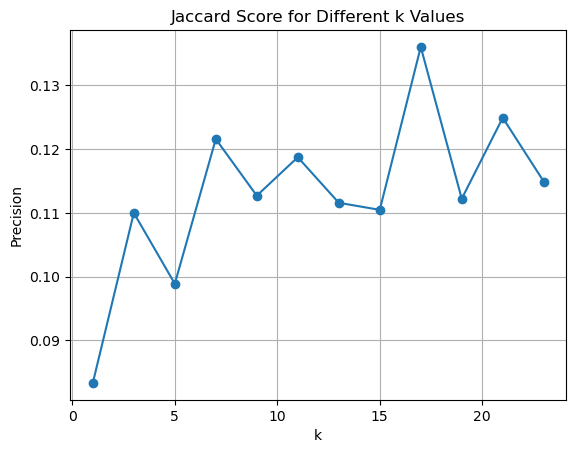

In [26]:
# tried different values here, see ui


with mlflow.start_run(run_name="k_opti_small_values", experiment_id=experiment_id) as parent:
    precision = []
    k_values = list(range(1, 25, 2))

    for k in k_values:
        with mlflow.start_run(run_name=f'child_{k}', nested=True) as child:
            print(f'RUN ID child_{k}:', child.info.run_id)

            parameters = {
                "preprocessing": 'bow',
                "feature": 'title_nltk',
                "k neighbors": k,
                "target": 'all_tags',
                "nb_tags_predicted": 5
            }
            mlflow.log_params(parameters)

            precision_moyenne, jaccard_moyen = predict_tags_using_knn(k=k)

            metrics = {
                "precision": precision_moyenne,
                "jaccard": jaccard_moyen
            }
            # multiple metrics
            mlflow.log_metrics(metrics)

            precision.append((k, jaccard_moyen))

    jaccard_moyen = [item[1] for item in precision]

    # Plot precision scores against k values
    plt.plot(k_values, jaccard_moyen, marker='o')
    plt.xlabel('k')
    plt.ylabel('Precision')
    plt.title('Jaccard Score for Different k Values')
    plt.grid(True)

    # Save the plot
    plt.savefig("./artifacts/jaccard_plot_1_25.png")
    # Log the saved figure using MLflow
    mlflow.log_artifact("./artifacts/jaccard_plot_1_25.png")

    # Show the plot (optional)
    plt.show()


# k=13 sur la moitie des donnes, jaccard = 0.11
# k=19 sur donnes completes, jaccard = 0.17


### 2.9 Influence du nb de topics prédits sur la précision


RUN ID child_3: dc79c4bcba204e129c9fca7dc9127d71
doc 0 : ['read', 'pdf', 'file', 'asset', 'folder']
real tags : ['java', 'android', 'pdf', 'android-intent', 'android-assets']
predicted : ['c#', '.net', 'c++']
precision : 0.0
jaccard : 0.0 

doc 1 : ['create', 'list', 'matrix', 'edge', 'list']
real tags : ['r', 'igraph', 'adjacency-list', 'adjacency-matrix', 'sna']
predicted : ['list', 'python', 'java']
precision : 0.0
jaccard : 0.0 

doc 2 : ['studio', 'intellij', 'error', 'cause', 'peer', 'authenticate']
real tags : ['java', 'android', 'ssl', 'intellij-idea', 'gradle']
predicted : ['android', 'android-studio', 'android-gradle-plugin']
precision : 0.2
jaccard : 0.14285714285714285 

doc 3 : ['ajax', 'type', 'post', 'post', 'method', 'php']
real tags : ['php', 'javascript', 'jquery', 'ajax', 'post']
predicted : ['javascript', 'post', 'php']
precision : 0.6
jaccard : 0.6 

doc 4 : ['descriptor', 'typeerror', 'type', 'self']
real tags : ['python', 'opencv', 'image-processing', 'computer-v

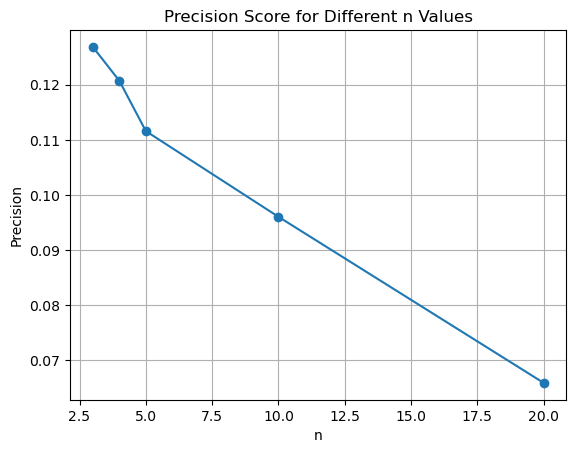

In [27]:
with mlflow.start_run(run_name="tags_opti", experiment_id=experiment_id) as parent:
    precision = []
    nb_tags = [3, 4, 5, 10, 20]

    for n in nb_tags:
        with mlflow.start_run(run_name=f'child_{n}', nested=True) as child:
            print(f'RUN ID child_{n}:', child.info.run_id)

            parameters = {
                "preprocessing": 'bow',
                "feature": 'title_nltk',
                "k neighbors": 13,
                "target": 'all_tags',
                "nb_tags_predicted": n
            }
            mlflow.log_params(parameters)

            precision_moyenne, jaccard_moyen = predict_tags_using_knn(k=13, n=n)

            metrics = {
                "precision": precision_moyenne,
                "jaccard": jaccard_moyen
            }

            # multiple metrics
            mlflow.log_metrics(metrics)

            precision.append((n, jaccard_moyen))

    jaccard_moyen = [item[1] for item in precision]

    # Plot precision scores against k values
    plt.plot(nb_tags, jaccard_moyen, marker='o')
    plt.xlabel('n')
    plt.ylabel('Precision')
    plt.title('Precision Score for Different n Values')
    plt.grid(True)

    # Save the plot
    plt.savefig("./artifacts/jaccard_plot_3_4_tags.png")
    # Log the saved figure using MLflow
    mlflow.log_artifact("./artifacts/jaccard_plot_3_4_tags.png")

    # Show the plot (optional)
    plt.show()



### 2.10 Preprocessing (feature et target)


In [28]:
# Nous avons besoin de transformer la target pdt le preprocessing (-> bow)
# mm si on ne s'sn sert pas vraiment, car grid_search.fit() n'accepte que des valeurs numériques.

# Avantage : on peut utiliser des metriques classiques pour le score (ici r2),
# mais ca n'a aucun sens metier interpretable.
# peut tjs etre utile si fortement correlé à notre precision score custom
# ou au score de similarité Jaccard

# Compliqué à faire dans le pipeline sckikit, qui transforme les features mais pas la target.
# TransformedTargetRegressor ne convient pas non plus ici : c'est un modele wrapper,
# utilisé apres le pipeline.
# trouvé qq "solutions" + ou - elegantes, mais rien de compatible à la fois avec sklearn et mlflow.

# Ici convertir les tags en bag of words ou les one hot encoder revient exactement au meme, donc
# autant utiliser le bow, on a deja le transformeur.


In [29]:
# Plus tard je vais me rendre compte que ce serait bcp mieux de tjs utiliser le mm dico ici


def token_list_into_bow(X):
    documents = X.tolist()
    # print(documents)
    gensim_dictionary = Dictionary(documents)
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]

    # Convert Gensim corpus to dense matrix
    bow_matrix = corpus2dense(corpus, num_terms=len(gensim_dictionary)).T

    return bow_matrix, gensim_dictionary


### 2.11 (tentative de) gridsearch


In [30]:
# Prend trop de ressources !
# les runs mlflow sont + pratiques pour encapsuler le code

# En plus je me demande si la gridsearch est une bonne idée pour le knn.
# deja pour la lda et la nmf j'avais des doutes
# a verifier mais pour ces modeles je pense qu'un dataset d'entrainement plus petit peut
# serieusement impacter le nb optimal pour l'hyperparam
# (voisins pour le knn, topics pour lda et nmf)


def pipe_knn(train_df=train_df, feature=feature, target='all_tags', test_df=test_df, metric='cosine'):
    # Load your training data and labels
    X_train = train_df[feature].values
    y_train = train_df[target].values

    X_bow_matrix, _ = token_list_into_bow(X_train)
    y_bow_matrix, _ = token_list_into_bow(y_train)

    # Create a KNN Regressor
    knn_regressor = KNeighborsRegressor(metric=metric)

    # Create a pipeline with preprocessing and a knn regressor, to simplify gridsearch
    pipe = Pipeline(steps=[
        ("knn_regressor", knn_regressor)
    ])

    # Define hyperparameters and their possible values for grid search
    param_grid = {
        'knn_regressor__n_neighbors': [11, 13, 15],
        'knn_regressor__weights': ['uniform'] # , 'distance'
    }

    # Create the GridSearchCV object with multiple scoring metrics
    # scoring = {'neg_mean_squared_error': 'neg_mean_squared_error', 'r2': 'r2'}
    grid_search = GridSearchCV(pipe, param_grid=param_grid,
                            scoring='r2', cv=3, verbose=1) # add, refit='precision' for multiple scoring

    # Fit the GridSearchCV object to your training data to perform hyperparameter tuning
    grid_search.fit(X_bow_matrix, y_bow_matrix)

    # Access the best hyperparameters
    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)

    # Create the KNN regressor with the best hyperparameters
    best_knn_regressor = KNeighborsRegressor(# metric=metric,
                                             n_neighbors=best_params['knn_regressor__n_neighbors'],
                                             weights=best_params['knn_regressor__weights'])

    # Create a pipeline with the preprocessor and the tuned knn regressor
    pipeline_with_tuned_knn = Pipeline(steps=[
        ("knn_regressor", best_knn_regressor)  # Use the tuned neighbor and weight values here
    ])

    # Perform cross-validation (on training set) and display the scores for each split
    # scoring = ['r2', 'neg_mean_squared_error']
    cv_scores = cross_validate(pipeline_with_tuned_knn, X_bow_matrix, y_bow_matrix, cv=5, scoring='r2')
    # print("Cross-Validation Scores (training):", '\n', cv_scores)
    print("Cross-Validation Scores:")
    pprint(cv_scores)
    for i, score in enumerate(cv_scores['test_score']):
        print(f"Split {i+1} : precision = {score}")


# crash le kernel
# pipe_knn()


### Checkpoint


In [31]:
quick_df = raw_data[::100]

train_df, test_df = train_test_split(quick_df, test_size=0.1, random_state=42)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)


In [32]:
# On oublie la gridsearchcv, mais on garde le scorer
# pour evaluer notre modele sur tt le training / testing set
# (pas seulement les 25 premieres lignes du set)


def pipe_knn(train_df=train_df, feature=feature, target='all_tags', test_df=test_df, metric='cosine'):
    # Load your training data and labels
    X_train = train_df[feature].values
    y_train = train_df[target].values

    X_bow_matrix, _ = token_list_into_bow(X_train)
    y_bow_matrix, _ = token_list_into_bow(y_train)

    # Create a KNN Regressor
    knn_regressor = KNeighborsRegressor(metric=metric)

    # Define hyperparameters and their possible values for tuning
    params = {
        'n_neighbors': 13,
        'weights': 'uniform'
    }

    # Create the KNN regressor with the specified hyperparameters
    knn_regressor.set_params(**params)

    # Fit the KNN regressor to your training data
    knn_regressor.fit(X_bow_matrix, y_bow_matrix)

    # Evaluate the model using a scorer
    scorer = make_scorer(r2_score)
    score = scorer(knn_regressor, X_bow_matrix[::100], y_bow_matrix[::100])
    print("R2 Score:", score)

    return knn_regressor


# Demande bcp trop de ressources sur le training set complet. (31.5 GiB pour y_pred)
# Il faut se contenter d'un sample.
# Utiliser un set de validation ici ?

# Du coup pour pouvoir utiliser jaccard en score, on a besoin de la méthode .predict() des classifiers.

pipe_knn()


R2 Score: 0.7985245331580839


KNeighborsRegressor(metric='cosine', n_neighbors=13)

## 3 Utilisation d'un classifier multilabel


### 3.1 nb de tags pris en compte


In [33]:
# Utiliser un regresseur permet de facilement travailler avec l'ensemble des tags, mais
# nécessite une méthode .predict() custom, et les prédictions sont très lentes :
# impossible d'évaluer notre modèle sur une partie importante du dataset,
# on doit se contenter d'un petit sample.

# Voyons si un regresseur multilabel peut résoudre ces 2 problèmes


In [34]:
# Reconstruire le dictionnaire {tag : frequence}
# pour travailler sur les n tags les + frequents

all_tags = [tag for tags in raw_data['all_tags'] for tag in tags]
print(f'Il y a {len(all_tags)} tags au total. \n')
print(f'Il y a {len(set(all_tags))} tags différents. \n')

# display(questions_tags)

# Fréquence
tag_frequencies_dict = {}
for tag in all_tags:
    tag_frequencies_dict[tag] = tag_frequencies_dict.get(tag, 0) + 1

# Sort the dictionary items by values in descending order
sorted_tag_frequencies = dict(sorted(tag_frequencies_dict.items(), key=lambda item: item[1], reverse=True))

# Extract tags and frequencies
tags = list(sorted_tag_frequencies.keys())
frequencies = list(sorted_tag_frequencies.values())

df_freq = pd.DataFrame({'Tag': tags, 'Frequency': frequencies})


Il y a 238327 tags au total. 

Il y a 15817 tags différents. 



In [35]:
def keep_most_frequent_tags(list_tags, df_freq=df_freq, lim=100):
    """
    Keep only the n most frequent tags (default 100).

    Parameters:
    - liste_tokens (list): The input list of tokens to be processed.
    - forbidden_list (set): A set of forbidden tokens, which includes stop words,
      tokens exceeding upper frequency limits, and tokens falling below lower frequency limits.

    Returns:
    list: A filtered list of tokens that excludes stop words, tokens exceeding upper frequency limits,
    and tokens falling below lower frequency limits.
    """

    mandatory_list = df_freq['Tag'][:lim].tolist()
    filtered_list = [token for token in list_tags if token in mandatory_list]

    return filtered_list


raw_data['top_tags_50'] = raw_data['all_tags'].apply(
    lambda x: keep_most_frequent_tags(x)
)

 # info targets vides
print(f'nb de targets desormais vides : {raw_data.loc[raw_data["top_tags_50"].apply(len) == 0, :].shape[0]} \
       (/ 50 000)', '\n')

display(raw_data.head())


nb de targets desormais vides : 2410        (/ 50 000) 



,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy,top_tags_50
0,2023-10-02 11:07:45,ImportError: cannot import name 'url_decode' f...,I am building a webapp using Flask. I imported...,"[python, flask, importerror, flask-login, werk...","[importerror, import, name, url]","[importerror, import, name, build, webapp, fla...","[importerror, import]","[build, webapp, import, flask, login, library,...",[python]
1,2023-09-25 09:05:11,Compilation error after upgrading to JDK 21 - ...,"After upgrading to JDK 21, I have the followin...","[spring-boot, compiler-errors, upgrade, lombok...","[compilation, error, upgrade, jdk, member, field]","[compilation, error, upgrade, jdk, member, fie...","[compilation, error, upgrade, member, field]","[upgrade, follow, compilation, error, project,...",[spring-boot]
2,2023-08-28 07:22:32,Differences between Langchain & LlamaIndex,I'm currently working on developing a chatbot ...,"[chatbot, openai-api, langchain, large-languag...",[difference],"[difference, work, develop, power, language, m...",[difference],"[work, develop, power, want, provide, response...",[]
3,2023-08-15 22:21:03,session not created: This version of ChromeDri...,I am running a Docker image from a Docker cont...,"[python, amazon-web-services, docker, google-c...","[session, create, version, chromedriver, suppo...","[session, create, version, chromedriver, suppo...","[session, create, version, support, version]","[run, image, container, environment, work, tod...","[python, amazon-web-services, docker, google-c..."
4,2023-08-01 08:16:21,Spring security method cannot decide pattern i...,When I try to run an application it fails to s...,"[java, spring-boot, eclipse, spring-security, ...","[spring, security, method, decide, pattern, bo...","[spring, security, method, decide, pattern, bo...","[spring, security, method, decide, pattern, ap...","[try, run, application, fail, start, throw, ex...","[java, spring-boot, eclipse]"


In [36]:
# MultiLabelBinarizer: Does not handle missing values directly. Missing values need to be handled
# before applying the transformation.
# not so sure about that


print(raw_data.shape)

data_50 = raw_data.loc[raw_data["top_tags_50"].apply(len) >= 0, :].copy()

print(data_50.shape, '\n')

display(data_50.head())


(47665, 9)
(47665, 9) 



,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy,top_tags_50
0,2023-10-02 11:07:45,ImportError: cannot import name 'url_decode' f...,I am building a webapp using Flask. I imported...,"[python, flask, importerror, flask-login, werk...","[importerror, import, name, url]","[importerror, import, name, build, webapp, fla...","[importerror, import]","[build, webapp, import, flask, login, library,...",[python]
1,2023-09-25 09:05:11,Compilation error after upgrading to JDK 21 - ...,"After upgrading to JDK 21, I have the followin...","[spring-boot, compiler-errors, upgrade, lombok...","[compilation, error, upgrade, jdk, member, field]","[compilation, error, upgrade, jdk, member, fie...","[compilation, error, upgrade, member, field]","[upgrade, follow, compilation, error, project,...",[spring-boot]
2,2023-08-28 07:22:32,Differences between Langchain & LlamaIndex,I'm currently working on developing a chatbot ...,"[chatbot, openai-api, langchain, large-languag...",[difference],"[difference, work, develop, power, language, m...",[difference],"[work, develop, power, want, provide, response...",[]
3,2023-08-15 22:21:03,session not created: This version of ChromeDri...,I am running a Docker image from a Docker cont...,"[python, amazon-web-services, docker, google-c...","[session, create, version, chromedriver, suppo...","[session, create, version, chromedriver, suppo...","[session, create, version, support, version]","[run, image, container, environment, work, tod...","[python, amazon-web-services, docker, google-c..."
4,2023-08-01 08:16:21,Spring security method cannot decide pattern i...,When I try to run an application it fails to s...,"[java, spring-boot, eclipse, spring-security, ...","[spring, security, method, decide, pattern, bo...","[spring, security, method, decide, pattern, bo...","[spring, security, method, decide, pattern, ap...","[try, run, application, fail, start, throw, ex...","[java, spring-boot, eclipse]"


### Checkpoint


In [37]:
quick_df = data_50[::100]

train_df, test_df = train_test_split(quick_df, test_size=0.1, random_state=42)

train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)


### 3.2 dictionnaire (gensim) standard


In [38]:
# Nécessaire pour predire sans data leak

_, standard_dict_title = token_list_into_bow(train_df[feature])


def token_list_into_bow_using_specific_dict(X, dict=standard_dict_title):
    documents = X.tolist()
    # print(documents)
    gensim_dictionary = dict
    corpus = [gensim_dictionary.doc2bow(doc) for doc in documents]

    # Convert Gensim corpus to dense matrix
    bow_matrix = corpus2dense(corpus, num_terms=len(gensim_dictionary)).T

    return bow_matrix


### 3.3 Score : comparaison training / testing set


In [39]:
def knn_classifier(train_df=train_df, feature=feature, k=13, target='top_tags_50', test_df=test_df,
                   dict=standard_dict_title):

    # Load training data and labels
    X_train = train_df[feature].values
    X_test = test_df[feature].values
    y_train = train_df[target].tolist()
    y_test = test_df[target].tolist()

    # training set
    X_bow_matrix = token_list_into_bow_using_specific_dict(X_train, dict)
    # testing set
    X_test_bow_matrix = token_list_into_bow_using_specific_dict(X_test, dict)

    # target encoding
    mlb = MultiLabelBinarizer()
    y_encoded = mlb.fit_transform(y_train)
    y_test_encoded = mlb.fit_transform(y_test)

    # Create a KNN classifier this time
    knn = KNeighborsClassifier()

    # Define hyperparameters and their possible values for tuning
    params = {
        'n_neighbors': k
    }

    # Create the KNN regressor with the specified hyperparameters
    knn.set_params(**params)

    # Fit the KNN regressor to your training data
    knn.fit(X_bow_matrix, y_encoded)

    # Evaluate the model on training data using precision
    print('SCORES TAGS ENCODÉS (MLB)', '\n')
    predictions = knn.predict(X_bow_matrix)

    scorer = precision_score
    score = scorer(predictions, y_encoded)
    print("Precision score (training set): ", score)

    # Evaluate the model on training data using jaccard similarity
    scorer = jaccard_score
    score = scorer(predictions, y_encoded)
    print("Jaccard similarity (training set): ", score)
    print('\n')

    # Evaluate the model on test data
    predictions = knn.predict(X_test_bow_matrix)
    scorer = precision_score
    score = scorer(predictions, y_test_encoded)
    print("Precision score (testing set): ", score)

    scorer = jaccard_score
    score = scorer(predictions, y_test_encoded)
    print("Jaccard similarity (testing set): ", score)

    return knn, mlb, dict


# knn_100, mlb_100, dict_100 = knn_classifier()

# pb precision ??
# OK hypothèse : j'ai modifié la fonction precision_score() pour qu'elle ne tienne pas compte de l'ordre.
# C'était + pratiquee pour comparer les tags predits aux tags reels (sous forme de listes de tokens)
# Mais si on les compare sous forme encodée, alors l'ordre importe. Pour ma fonction presque tous les
# mots sont identiques : 000000000000000000010000000000000000000...

# Solution : utiliser notre fonction custom seulement pour comparer les tokens,
# mais pas les representations bag of words.

# checker exemples


In [40]:
def knn_classifier(train_df=train_df, feature=feature, k=13, target='top_tags_50', test_df=test_df,
                   dict=standard_dict_title):

    # Load training data and labels
    X_train = train_df[feature].values
    X_test = test_df[feature].values
    y_train = train_df[target].tolist()
    y_test = test_df[target].tolist()

    # training set
    X_bow_matrix = token_list_into_bow_using_specific_dict(X_train, dict)
    # testing set
    X_test_bow_matrix = token_list_into_bow_using_specific_dict(X_test, dict)

    # target encoding
    mlb_train = MultiLabelBinarizer()
    y_encoded = mlb_train.fit_transform(y_train)

    # Create a KNN classifier this time
    knn = KNeighborsClassifier()

    # Define hyperparameters and their possible values for tuning
    params = {
        'n_neighbors': k
    }

    # Create the KNN regressor with the specified hyperparameters
    knn.set_params(**params)

    # Fit the KNN regressor to your training data
    knn.fit(X_bow_matrix, y_encoded)

    predictions_train = knn.predict(X_bow_matrix)
    predictions_test = knn.predict(X_test_bow_matrix)

    print('SCORES TAGS (TOKENS)', '\n')

    predicted_tags_train = mlb_train.inverse_transform(predictions_train)
    predicted_tags_test = mlb_train.inverse_transform(predictions_test)

    # Evaluate the model on training data using precision
    scorer = precision_score
    score = scorer(predicted_tags_train, y_train)
    print("Precision score (training set): ", score)

    # Evaluate the model on training data using jaccard similarity
    scorer = jaccard_score
    score = scorer(predicted_tags_train, y_train)
    print("Jaccard similarity (training set): ", score)
    print('\n')

    # Evaluate the model on test data
    scorer = precision_score
    score = scorer(predicted_tags_test, y_test)
    print("Precision score (testing set): ", score)

    scorer = jaccard_score
    score = scorer(predicted_tags_test, y_test)
    print("Jaccard similarity (testing set): ", score)


    return knn, mlb_train, dict


knn_50, mlb_50, dict_50 = knn_classifier()

# Ah, enfin qqch de coherent !
# bcp moins bon du coup, mais coherent

# En fait la précision "profite" des cas, qui semblent nombreux ici, où un seul tag est prédit.
# Jaccard est vraiment + robuste


SCORES TAGS (TOKENS) 

Precision score (training set):  0.06993006993006994
Jaccard similarity (training set):  0.06449106449106448


Precision score (testing set):  0.041666666666666664
Jaccard similarity (testing set):  0.041666666666666664


### Checkpoint (+ choix target)


In [41]:
def create_top_tags_feature(raw_data=raw_data, n=50, slice=20):
    raw_data['top_tags'] = raw_data['all_tags'].apply(
        lambda x: keep_most_frequent_tags(x, lim=n)
    )

    # Pas sûr que la ligne suivante soit indispensable
    data = raw_data.loc[raw_data['top_tags'].apply(len) >= 0, :].copy()
    print(data.shape, '\n')

    slice_df = data[::slice]
    # slice_df.reset_index(drop=True, inplace=True)

    train_df, test_df = train_test_split(slice_df, test_size=0.1, random_state=42)

    train_df.reset_index(drop=True, inplace=True)
    test_df.reset_index(drop=True, inplace=True)


    return train_df, test_df


train_df, test_df = create_top_tags_feature(n=30, slice=100)
_, standard_dict_title = token_list_into_bow(train_df[feature])


(47665, 10) 



In [42]:
display(raw_data.head())


,CreationDate,title,body,all_tags,title_nltk,body_nltk,title_spacy,body_spacy,top_tags_50,top_tags
0,2023-10-02 11:07:45,ImportError: cannot import name 'url_decode' f...,I am building a webapp using Flask. I imported...,"[python, flask, importerror, flask-login, werk...","[importerror, import, name, url]","[importerror, import, name, build, webapp, fla...","[importerror, import]","[build, webapp, import, flask, login, library,...",[python],[python]
1,2023-09-25 09:05:11,Compilation error after upgrading to JDK 21 - ...,"After upgrading to JDK 21, I have the followin...","[spring-boot, compiler-errors, upgrade, lombok...","[compilation, error, upgrade, jdk, member, field]","[compilation, error, upgrade, jdk, member, fie...","[compilation, error, upgrade, member, field]","[upgrade, follow, compilation, error, project,...",[spring-boot],[]
2,2023-08-28 07:22:32,Differences between Langchain & LlamaIndex,I'm currently working on developing a chatbot ...,"[chatbot, openai-api, langchain, large-languag...",[difference],"[difference, work, develop, power, language, m...",[difference],"[work, develop, power, want, provide, response...",[],[]
3,2023-08-15 22:21:03,session not created: This version of ChromeDri...,I am running a Docker image from a Docker cont...,"[python, amazon-web-services, docker, google-c...","[session, create, version, chromedriver, suppo...","[session, create, version, chromedriver, suppo...","[session, create, version, support, version]","[run, image, container, environment, work, tod...","[python, amazon-web-services, docker, google-c...",[python]
4,2023-08-01 08:16:21,Spring security method cannot decide pattern i...,When I try to run an application it fails to s...,"[java, spring-boot, eclipse, spring-security, ...","[spring, security, method, decide, pattern, bo...","[spring, security, method, decide, pattern, bo...","[spring, security, method, decide, pattern, ap...","[try, run, application, fail, start, throw, ex...","[java, spring-boot, eclipse]",[java]


In [43]:
knn_50, mlb_50, dict_50 = knn_classifier(train_df=train_df, k=19, target='top_tags', test_df=test_df)

# Ici je teste differentes valeurs pour le nb de top_tags.
# J'espérais qu'en prenant en compte davantage de tags, on aurait moins de targets vides
# et donc (hopefully) moins de prédictions nulles.

# Problèmes : le tps d'entrainement explose...
# # Si on garde les 5000 tags les + frequents on passe de qq minutes (2 min pour 50 tags) à...
# c'est long ! (+ d'une heure)
# Pourtant les targets st tjs assez vides, et bcp de prédictions .predict() st tjs nulles.

# ... et le score chute.

# En fait mon knn bricolé au début était pas si mal


SCORES TAGS (TOKENS) 

Precision score (training set):  0.1561771561771562
Jaccard similarity (training set):  0.155011655011655


Precision score (testing set):  0.22916666666666666
Jaccard similarity (testing set):  0.22916666666666666


In [44]:
def string_query_into_bow_vector(query, dictionary):
    query_token_list = preprocess_text(query)
    query_bow = dictionary.doc2bow(query_token_list)
    query_vector = corpus2dense([query_bow], num_terms=len(dictionary)).T

    return query_vector


### 3.4 predict...


In [45]:
# predict


def predict_tags(test_data, model, mlb_encoder, dictionary):
    # Transform test features
    query = string_query_into_bow_vector(test_data, dictionary)

    # Make predictions
    predicted_labels = model.predict(query)

    # Inverse transform predicted labels
    predicted_tags_tuple = mlb_encoder.inverse_transform(predicted_labels)
    predicted_tags = list(predicted_tags_tuple[0]) # mlb retourne un array

    return query, predicted_tags


def test_prediction(index=0):
    test_data = test_df['title'][index]
    query, predicted_tags = predict_tags(test_data)

    print(f"All tags : {test_df['all_tags'][index]}")
    print(f"Target : {test_df['top_tags'][index]}")
    print(f"Predicted : {predicted_tags}", '\n')

    # scores
    scorer = precision_topics
    score = scorer(predicted_tags, test_df['top_tags'][index])
    print("Precision score : ", score)

    scorer = jaccard_similarity
    score = scorer(predicted_tags, test_df['top_tags'][index])
    print("Jaccard similarity : ", score)
    print('\n')


test_prediction()


All tags : ['java', 'swing', 'user-interface', 'swt', 'awt']
Target : ['java']
Predicted : [] 

Precision score :  0
Jaccard similarity :  0.0




In [46]:
for i in range(0, 10):
    test_prediction(i)

# bcp de predictions nulles


All tags : ['java', 'swing', 'user-interface', 'swt', 'awt']
Target : ['java']
Predicted : [] 

Precision score :  0
Jaccard similarity :  0.0


All tags : ['javascript', 'node.js', 'unit-testing', 'jestjs', 'aws-sdk']
Target : ['javascript', 'node.js']
Predicted : [] 

Precision score :  0
Jaccard similarity :  0.0


All tags : ['android', 'android-studio', 'imageview', 'gif', 'splash-screen']
Target : ['android']
Predicted : [] 

Precision score :  0
Jaccard similarity :  0.0


All tags : ['python', 'amazon-web-services', 'logging', 'aws-lambda', 'amazon-cloudwatch']
Target : ['python']
Predicted : [] 

Precision score :  0
Jaccard similarity :  0.0


All tags : ['javascript', 'jquery', 'ajax', 'api', 'ecmascript-6']
Target : ['javascript', 'jquery']
Predicted : [] 

Precision score :  0
Jaccard similarity :  0.0


All tags : ['python', 'postgresql', 'python-3.x', 'sqlalchemy', 'flask-sqlalchemy']
Target : ['python', 'python-3.x']
Predicted : [] 

Precision score :  0
Jaccard similar

### 3.5 ... VS predict_proba


In [47]:
def always_predict_tags(test_data, knn_model=knn_50, mlb_encoder=mlb_50, dictionary=dict_50, top_n=5):
    # Transform test features
    query = string_query_into_bow_vector(test_data, dictionary)

    # Make predictions and get probabilities
    probabilities = knn_model.predict_proba(query)
    # print(probabilities[:3])

    # Extract tags from the mlb_encoder
    tags = mlb_encoder.classes_

    # Create a dictionary to store results
    results = {}

    # Iterate over probabilities and tags
    for i, tag in enumerate(tags):
        # Extract the probability for the current tag
        probability = probabilities[i][0][0]
        # Store the probability with the tag as the key
        results[tag] = probability

    # Sort the dictionary items by values in descending order
    sorted_results = dict(sorted(results.items(), key=lambda item: item[1], reverse=True))
    predicted_tags = list(sorted_results)[:top_n]
    # Construct a list of tuples containing tags and their corresponding probabilities
    tags_with_probas = [(tag, sorted_results[tag]) for tag in predicted_tags]

    return tags_with_probas


def test_prediction(index=0):
    predicted_tags = always_predict_tags(test_df['title'][index])
    print(test_df['all_tags'][index])
    print(test_df['top_tags'][index])
    print(predicted_tags, '\n')


test_prediction()

# bcp de probas == 1 alors qu'on n'avait pas de prediction (ou 1) sur cet exemple ??
# On a exactement le problème inverse !


['java', 'swing', 'user-interface', 'swt', 'awt']
['java']
[('.net', 1.0), ('arrays', 1.0), ('asp.net', 1.0), ('asp.net-mvc', 1.0), ('css', 1.0)] 



In [48]:
for i in range(0, 10):
    test_prediction(i)

# bcp trop de valeurs à 1
# predit svt la mm chose

# pour le knn on peut tjs utiliser notre predict custom, mais pour les autres modeles
# il faudra une difference plus nette.


['java', 'swing', 'user-interface', 'swt', 'awt']
['java']
[('.net', 1.0), ('arrays', 1.0), ('asp.net', 1.0), ('asp.net-mvc', 1.0), ('css', 1.0)] 

['javascript', 'node.js', 'unit-testing', 'jestjs', 'aws-sdk']
['javascript', 'node.js']
[('arrays', 1.0), ('asp.net', 1.0), ('asp.net-mvc', 1.0), ('css', 1.0), ('html', 1.0)] 

['android', 'android-studio', 'imageview', 'gif', 'splash-screen']
['android']
[('arrays', 1.0), ('asp.net', 1.0), ('asp.net-mvc', 1.0), ('ios', 1.0), ('iphone', 1.0)] 

['python', 'amazon-web-services', 'logging', 'aws-lambda', 'amazon-cloudwatch']
['python']
[('.net', 1.0), ('android', 1.0), ('arrays', 1.0), ('asp.net', 1.0), ('asp.net-mvc', 1.0)] 

['javascript', 'jquery', 'ajax', 'api', 'ecmascript-6']
['javascript', 'jquery']
[('android', 1.0), ('arrays', 1.0), ('asp.net', 1.0), ('asp.net-mvc', 1.0), ('css', 1.0)] 

['python', 'postgresql', 'python-3.x', 'sqlalchemy', 'flask-sqlalchemy']
['python', 'python-3.x']
[('.net', 1.0), ('arrays', 1.0), ('asp.net', 1.0)

## 4 Autres classifieur multilabels


### 4.1 Logistic regression


### checkpoint


In [62]:
train_df, test_df = create_top_tags_feature(n=200, slice=3)
_, standard_dict_title = token_list_into_bow(train_df[feature])


(47665, 10) 



In [61]:
# pas nativement mutilabel -> approche one vs rest via MultiOutputClassifier()


def logistic_regression_classifier(train_df=train_df, feature=feature, dict=standard_dict_title,
                                   target='top_tags', test_df=test_df):

    X_train = train_df[feature].values
    X_test = test_df[feature].values
    y_train = train_df[target].tolist()
    y_test = test_df[target].tolist()

    # training set
    X_bow_matrix = token_list_into_bow_using_specific_dict(X_train, dict)
    # testing set
    X_test_bow_matrix = token_list_into_bow_using_specific_dict(X_test, dict)

    # target encoding
    mlb_train = MultiLabelBinarizer()
    y_encoded = mlb_train.fit_transform(y_train)

    # Create a Logistic Regression classifier
    logistic_reg = LogisticRegression(random_state=42)

    # Create a MultiOutputClassifier with the Logistic Regression classifier
    multi_output_classifier = MultiOutputClassifier(logistic_reg)

    # Fit the MultiOutputClassifier to your training data
    multi_output_classifier.fit(X_bow_matrix, y_encoded)

    predictions_train = multi_output_classifier.predict(X_bow_matrix)
    predictions_test = multi_output_classifier.predict(X_test_bow_matrix)

    print('SCORES TAGS (TOKENS)', '\n')

    predicted_tags_train = mlb_train.inverse_transform(predictions_train)
    predicted_tags_test = mlb_train.inverse_transform(predictions_test)

    # Evaluate the model on training data using precision
    scorer = precision_score
    score = scorer(predicted_tags_train, y_train)
    print("Precision score (training set): ", score)

    # Evaluate the model on training data using jaccard similarity
    scorer = jaccard_score
    score = scorer(predicted_tags_train, y_train)
    print("Jaccard similarity (training set): ", score)
    print('\n')

    # Evaluate the model on test data
    scorer = precision_score
    score = scorer(predicted_tags_test, y_test)
    print("Precision score (testing set): ", score)

    scorer = jaccard_score
    score = scorer(predicted_tags_test, y_test)
    print("Jaccard similarity (testing set): ", score)


    return multi_output_classifier, mlb_train


multi_output_classifier, mlb_50 = logistic_regression_classifier()


KeyboardInterrupt: 

In [57]:
# predict


def test_prediction(index=0):
    _, predicted_tags = predict_tags(test_df['title'][index], multi_output_classifier, mlb_50, standard_dict_title)
    print(test_df['all_tags'][index])
    print(test_df['top_tags'][index])
    print(predicted_tags, '\n')


test_prediction()


['php', 'arrays', 'sorting', 'associative-array', 'custom-function']
['php', 'arrays']
['arrays'] 



In [59]:
for i in range(1,10):
    test_prediction(i)


['java', 'arrays', 'string', 'arraylist', 'initialization']
['java', 'arrays', 'string']
['java'] 

['java', 'javascript', 'json', 'spring', 'integer']
['java', 'javascript', 'json', 'spring']
['javascript'] 

['xmlhttprequest', 'jersey', 'angularjs', 'java-ee-6', 'cors']
['angularjs']
['angularjs'] 

['python', 'animation', 'matplotlib', 'pyqt', 'pyqt4']
['python']
[] 

['android', 'storage', 'file-permissions', 'java-io', 'android-file']
['android']
[] 

['date', 'parsing', 'datetime', 'date-formatting', 'java-time']
[]
['java'] 

['java', 'eclipse', 'wildfly', 'wildfly-8', 'jboss-tools']
['java']
[] 

['python', 'django', 'authentication', 'csrf', 'django-csrf']
['python', 'django']
[] 

['arrays', 'symfony', 'doctrine-orm', 'twig', 'longtext']
['arrays']
[] 



In [54]:
# predict proba


def test_prediction(index=0):
    predicted_tags = always_predict_tags(test_df['title'][index], multi_output_classifier, mlb_50, standard_dict_title)
    print(test_df['all_tags'][index])
    print(test_df['top_tags'][index])
    print(predicted_tags, '\n')


for i in range(0,7):
    test_prediction(i)


['python', 'json', 'pandas', 'dataframe', 'pretty-print']
['python', 'json', 'pandas']
[('typescript', 0.9981087970323879), ('mysql', 0.997769540893475), ('spring', 0.9961814488967182), ('linux', 0.9958591365163643), ('asp.net-mvc', 0.995031378501557)] 

['c#', '.net', 'wcf', 'service', '.net-core']
['c#', '.net']
[('typescript', 0.9970719440595849), ('reactjs', 0.9970616028385292), ('pandas', 0.9968071169300189), ('c', 0.9963520617106969), ('css', 0.9961274948037907)] 

['asp.net', '.net', 'iis', 'iis-7.5', 'microsoft-web-deploy']
['asp.net', '.net']
[('arrays', 0.9985192267932762), ('pandas', 0.9979282689747422), ('css', 0.9968729415991295), ('sql', 0.9961956603293665), ('python-3.x', 0.9949020818050779)] 

['css', 'input', 'autocomplete', 'font-size', 'tailwind-css']
['css']
[('arrays', 0.9963196909746237), ('pandas', 0.9962426437829432), ('asp.net-mvc', 0.9956317959719753), ('json', 0.9954607809144042), ('typescript', 0.9945455721282215)] 

['c#', 'wcf', 'wcf-security', 'wcf-bindin

### 4.2 SGDClassifier


In [ ]:
# using default SVM


def sgd_classifier(train_df=train_df, feature=feature, target='top_tags',
                   dict=standard_dict_title, test_df=test_df):

    # Load your training data and labels
    X_train = train_df[feature].values
    y_train = train_df[target].tolist()

    # Training set
    X_bow_matrix = token_list_into_bow_using_specific_dict(X_train, dict)

    # Target encoding
    mlb = MultiLabelBinarizer()
    y_encoded = mlb.fit_transform(y_train)

    # Create an SGDClassifier with default parameters
    sgd_clf = SGDClassifier(random_state=42)  # default loss='hinge', gives a linear SVM

    # Create a MultiOutputClassifier with the SGD classifier
    multi_output_classifier = MultiOutputClassifier(sgd_clf)

    # Fit the MultiOutputClassifier to your training data
    multi_output_classifier.fit(X_bow_matrix, y_encoded)

    # Evaluate the model using a scorer
    scorer = custom_jacc_scorer
    score = scorer(multi_output_classifier, X_bow_matrix, y_encoded)
    print("Score : ", score)

    return multi_output_classifier, mlb


multi_output_classifier_svm, mlb_50 = sgd_classifier()

# tres bon score, bcp + rapide


In [ ]:
# predict (best score)


def test_prediction(index=0):
    predicted_tags = predict_tags(test_df['title'][index], multi_output_classifier_svm, mlb_50, standard_dict_title)
    print(test_df['all_tags'][index])
    print(test_df['top_tags'][index])
    print(predicted_tags, '\n')


for i in range(0,7):
    test_prediction(i)


In [ ]:
# predict proba


def test_prediction(index=0):
    predicted_tags = always_predict_tags(test_df['title'][index], multi_output_classifier_svm, mlb_50, standard_dict_title)
    print(test_df['all_tags'][index])
    print(test_df['top_tags'][index])
    print(predicted_tags, '\n')


# test_prediction(0)

# Ne fonctionne pas, la SVM du SGDClassifier ne possède pas la méthode predict_proba


In [ ]:
# using logistic reg


def sgd_classifier(train_df=train_df, feature=feature, target='top_tags',
                   dict=standard_dict_title, test_df=test_df):

    # Load your training data and labels
    X_train = train_df[feature].values
    y_train = train_df[target].tolist()

    # Training set
    X_bow_matrix = token_list_into_bow_using_specific_dict(X_train, dict)

    # Target encoding
    mlb = MultiLabelBinarizer()
    y_encoded = mlb.fit_transform(y_train)

    # Create an SGDClassifier with default parameters
    sgd_clf = SGDClassifier(random_state=42, loss='log_loss')  # for logistic regression

    # Create a MultiOutputClassifier with the SGD classifier
    multi_output_classifier = MultiOutputClassifier(sgd_clf)

    # Fit the MultiOutputClassifier to your training data
    multi_output_classifier.fit(X_bow_matrix, y_encoded)

    # Evaluate the model using a scorer
    scorer = custom_jacc_scorer
    score = scorer(multi_output_classifier, X_bow_matrix, y_encoded)
    print("Score : ", score)

    return multi_output_classifier, mlb


multi_output_classifier, mlb_50 = sgd_classifier()


### 4.3 Random forest


In [ ]:
# train_df, test_df = create_top_n_tags_feature(n=50, slice=50)


In [ ]:
def random_forest_classifier(train_df=train_df, feature=feature, target='top_tags',
                             dict=standard_dict_title, test_df=test_df):

    # Load your training data and labels
    X_train = train_df[feature].values
    y_train = train_df[target].tolist()

    # Training set
    X_bow_matrix = token_list_into_bow_using_specific_dict(X_train, dict)

    # Target encoding
    mlb = MultiLabelBinarizer()
    y_encoded = mlb.fit_transform(y_train)

    # Create a Random Forest Classifier with default parameters
    rf_clf = RandomForestClassifier(random_state=42)

    # Create a MultiOutputClassifier with the Random Forest Classifier
    multi_output_classifier = MultiOutputClassifier(rf_clf)

    # Fit the MultiOutputClassifier to your training data
    multi_output_classifier.fit(X_bow_matrix, y_encoded)

    # Evaluate the model using a scorer
    scorer = custom_jacc_scorer
    score = scorer(multi_output_classifier, X_bow_matrix, y_encoded)
    print("Score : ", score)

    return multi_output_classifier, mlb


multi_output_classifier_rf, mlb_50_rf = random_forest_classifier()

# + lent
# score wow


In [ ]:
# predict


def test_prediction(index=0):
    predicted_tags = predict_tags(test_df['title'][index], multi_output_classifier_rf, mlb_50_rf, standard_dict_title)
    print(test_df['all_tags'][index])
    print(test_df['top_tags'][index])
    print(predicted_tags, '\n')


for i in range(0,7):
    test_prediction(i)


In [ ]:
# predict proba


def test_prediction(index=0):
    predicted_tags = always_predict_tags(test_df['title'][index], multi_output_classifier_rf, mlb_50_rf, standard_dict_title)
    print(test_df['all_tags'][index])
    print(test_df['top_tags'][index])
    print(predicted_tags, '\n')


for i in range(0,7):
    test_prediction(i)


## 5 Drift


In [ ]:
raw_data['CreationDate'] = pd.to_datetime(raw_data['CreationDate'])

raw_data['year_month'] = raw_data['CreationDate'].map(lambda dt: dt.strftime('%Y-%m'))

print(raw_data['year_month'].min())
print(raw_data['year_month'].max())


In [ ]:
grouped_month = raw_data.groupby('year_month').size().to_frame("count_per_month").reset_index()

fig, ax = plt.subplots(figsize=(12, 3))  # Adjust the figsize as needed

grouped_month.plot(kind='bar', x='year_month', y='count_per_month', fontsize=12, ax=ax, width=0.8)
plt.title('nb questions par mois', fontsize=18, pad=20)
plt.legend(loc='upper right', fontsize=12)
plt.xticks(fontsize=5)
plt.show()


In [ ]:
# Concernant l’analyse de la stabilité du modèle, il est attendu de prendre un dataset par mois de questions
# sur un an, et de mesurer l’évolution des mesures et scores du modèle défini, afin d’en conclure une
# stabilité ou pas d’un modèle de référence établi sur des questions antérieures à cette période.

# test rapide avec logistic reg

month = []

unique_values = np.sort(raw_data['year_month'].unique())
print(len(unique_values))
# print(unique_values)

for mois in unique_values[:13]:
    month.append(raw_data.loc[raw_data['year_month'] == mois, :].copy())

print(len(month))


In [ ]:
display(month[1].head())


In [ ]:
display(month[12].head()) # last one


In [ ]:
# add mlflow

logistic_reg, mlb = sgd_classifier(train_df=month[1])

for i in range(2, 13):
    train_df = month[i]
    X_train = train_df['title_nltk'].values
    y_train = train_df['top_tags_50'].tolist()

    # Training set
    X_bow_matrix = token_list_into_bow_using_specific_dict(X_train, standard_dict_title)

    # Target encoding
    y_encoded = mlb.fit_transform(y_train)

    score_next_month = custom_jacc_scorer(logistic_reg, X_bow_matrix, y_encoded)
    print(score_next_month)


# graph
# tester evidently AI ?
# use mlflow recipe ?


## NN Models


In [ ]:
# pb : dim bow trop importante,
# Ca n'a aucun sens d'entrainer un réseau neuronal sur autant de poids / biais
# avec mes ressources
# (en + la plupart seraient = 0, pas idéal)

# add Dimensionality Reduction ? (pca? lda/nmf?)

# On comparera plutôt les modèles classiques et le NN (réseau neuronaux) sur les embeddings, denses,
# en partie 4_2 (notebook suivant)
